In [1]:
import os
gemini_key = os.getenv("gemini_api_key")

In [33]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model= "gemini-2.0-flash-lite", temperature = 0, google_api_key = gemini_key, convert_system_message_to_human=True)
# llm = ChatGoogleGenerativeAI(model= "gemini-2.0-flash", temperature = 0, google_api_key = gemini_key, convert_system_message_to_human=True)

In [3]:
promp = f"give me the name of leadership team of shopify with their linkedin url only"
ans = llm.invoke(promp)

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


In [4]:
ans.content

'Okay, here\'s the leadership team of Shopify with their LinkedIn URLs. Please note that leadership roles can change, so it\'s always a good idea to double-check on the Shopify website or LinkedIn for the most up-to-date information.\n\n*   **Tobias Lütke, CEO:** [https://www.linkedin.com/in/tlutke/](https://www.linkedin.com/in/tlutke/)\n\n*   **Jeff Hoffmeister, CFO:** [https://www.linkedin.com/in/jeff-hoffmeister-4444444/](https://www.linkedin.com/in/jeff-hoffmeister-4444444/)\n\n*   **Kaz Nejatian, COO:** [https://www.linkedin.com/in/nejatian/](https://www.linkedin.com/in/nejatian/)\n\n*   **Erin Zipes, Chief Legal Officer & Corporate Secretary:** [https://www.linkedin.com/in/erin-zipes-5440441/](https://www.linkedin.com/in/erin-zipes-5440441/)\n\nIt\'s recommended to visit the Shopify investor relations website or their official "About Us" page for the most current list of executives.'

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [4]:
_set_env("LC_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Research-Agent"

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affliation of the analyst."
    )
    name: str= Field(
        description="Name of the analyst(Name of the human who is analyst)."
    )
    role: str= Field(
        description="Role of the analyst in the context of the topic."
    )
    description:str = Field(
        description="Description of the analyst focus, concern and motives."
    )
    
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst]= Field(
        description="Comprehensive list of analysts with thier roles and affiliation"
    ) 

class GenerateAnalystState(TypedDict):
    topic: str
    max_analyst: str
    human_analyst_feedback: str
    analysts: List[Analyst]

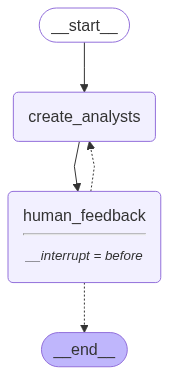

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage

def create_analysts(state: GenerateAnalystState):
    # if "max_analyst" not in state:
    #     raise ValueError("Expected 'max_analyst' key in state")
    topic= state["topic"]
    max_analysts = state.get("max_analysts", 3)
    human_analyst_feedback = state.get("human_analyst_feedback", "")
    analyst_instructions=f"""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

    1. First, review the research topic:
    {topic}
            
    2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
    {human_analyst_feedback}
        
    3. Determine the most interesting themes based upon documents and / or feedback above.
                        
    4. Pick the top {max_analysts} themes.

    5. Assign one analyst to each theme."""
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    # system_message = analyst_instructions.format(topic = topic, max_analysts = max_analysts, human_analyst_feedback = human_analyst_feedback)
    
    analysts = structured_llm.invoke([analyst_instructions]+[HumanMessage(content="generate the set of analysts.")])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystState):
    
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"
    return END

builder = StateGraph(GenerateAnalystState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before = ["human_feedback"], checkpointer = memory)

display(Image(graph.get_graph(xray= 1).draw_mermaid_png()))

In [17]:
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "7"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analyst":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Name: Alice Johnson
Affiliation: Independent AI Consultant
Role: Technology Adoption Strategist
Description: Focuses on the practical applications and benefits of new technologies in AI. Concerned with ease of use, development time, and real-world performance.
--------------------------------------------------
Name: Bob Williams
Affiliation: Large Language Model Security Firm
Role: AI Security Analyst
Description: Dedicated to identifying and mitigating security vulnerabilities in AI frameworks. Concerned about potential risks, exploits, and data privacy issues associated with LangGraph.
--------------------------------------------------
Name: Dr. Carol Lee
Affiliation: Academic AI Research Lab
Role: AI Research Scientist
Description: Interested in the theoretical underpinnings and potential for innovation in AI frameworks. Focuses on LangGraph's architecture, scalability, and ability to advance the field.
--------------------------------------------------


In [18]:
# memory.delete_thread(thread["configurable"]["thread_id"])

In [19]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [20]:
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective."}, as_node="human_feedback")

{'configurable': {'thread_id': '7',
  'checkpoint_ns': '',
  'checkpoint_id': '1f075e6e-968e-6a43-8002-808fe913b342'}}

In [21]:
for event in graph.stream(None, thread, stream_mode= "values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Alice Johnson
Affiliation: Independent AI Consultant
Role: Technology Adoption Strategist
Description: Focuses on the practical applications and benefits of new technologies in AI. Concerned with ease of use, development time, and real-world performance.
--------------------------------------------------
Name: Bob Williams
Affiliation: Large Language Model Security Firm
Role: AI Security Analyst
Description: Dedicated to identifying and mitigating security vulnerabilities in AI frameworks. Concerned about potential risks, exploits, and data privacy issues associated with LangGraph.
--------------------------------------------------
Name: Dr. Carol Lee
Affiliation: Academic AI Research Lab
Role: AI Research Scientist
Description: Interested in the theoretical underpinnings and potential for innovation in AI frameworks. Focuses on LangGraph's architecture, scalability, and ability to advance the field.
--------------------------------------------------


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Name: Dr. Anya Sharma
Affiliation: Large Language Model Corporation
Role: Chief AI Architect
Description: Focuses on the scalability and efficiency of LangGraph in enterprise environments. Concerned with the integration challenges and long-term maintenance costs.
--------------------------------------------------
Name: Raj Patel
Affiliation: AI Startup Inc.
Role: Founder and CEO
Description: Interested in the rapid prototyping and experimentation capabilities of LangGraph. Motivated by the potential for quick iteration and market validation.
--------------------------------------------------
Name: Dr. Kenji Tanaka
Affiliation: Independent AI Researcher
Role: AI Ethics Consultant
Description: Investigates the theoretical limitations and potential biases introduced by LangGraph's graph-based approach. Concerned with ensuring fairness and transparency in AI agent interactions.
--------------------------------------------------


In [22]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '7',
  'checkpoint_ns': '',
  'checkpoint_id': '1f075e6e-b261-6b63-8004-a64004a6daaf'}}

In [59]:
for event in graph.stream(None, thread, stream_mode= 'values'):
    print("--Node--")
    print(event.keys())
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
dict_keys(['topic', 'human_analyst_feedback', 'analysts', 'sections'])
topic
State Message ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='d23b6a04-5b9a-4d8c-8e28-bebc849530c0')]


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Hello, I'm Dr. Anya Sharma, Chief AI Architect. I'm focusing on the scalability and efficiency of LangGraph in enterprise environments, particularly the integration challenges and long-term maintenance costs.\n\nYes, I'm working on an article about the benefits of adopting LangGraph as an agent framework. To make it truly impactful, I want to move beyond the surface-level advantages. What are some *specific*, non-obvious benefits that enterprises might not immediately realize when considering LangGraph?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-51271b6f-cac0-4323-88a2-577bbd4ed66e-0' usage_metadata={'input_tokens': 292, 'output_tokens': 102, 'total_tokens': 394, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query wiki ==> search_query='LangGraph agent framework benefits for enterprises scalability efficiency integration challenges long-term maintenance costs'
search Query ==> search_query='LangGraph agent framework benefits for enterprises: scalability, efficiency, integration challenges, long-term maintenance costs, non-obvious advantages'
Context ==> ['<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>\nIn fact, the rapid adoption of AI agents by companies indicates a strategic shift. Early movers are using AI agents to handle tasks that were once bottlenecks, gaining an edge in customer responsiveness, data analysis, and innovation capacity. Using a framework like LangGraph ensures these AI initiatives are scalable and maintainable, so one is building a long-term strategic asset, not just a demo or one-off script.\n\n### Practical Gains: Save Time and Money While Reducing Errors [...] Another advantage of the LangGraph approach is that one can precisely c

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="One specific benefit of LangGraph is its ability to provide control and predictability, allowing users to visualize, debug, and optimize agent flows with precision [1]. LangGraph's graph-based architecture helps avoid unexpected behavior from agents [1]. It also scales from prototypes to production [1]. LangGraph supports features like caching results, retrying on failure, and handling long-running tasks, which are needed in production environments [2]. LangGraph applications offer features like scalable infrastructure and self-hosted deployment options [2]. LangGraph also has a state management system that stores information and enables better state management and debugging [2]. The visual workflow design enhances maintainability, and it allows for more granular control over agent actions [3].\n\n[1] medium.com/@vikaskumarsingh_60821/langgraph-the-future-of-production-grade-ai-agent-architectures-623d68dbbfb6\n[2] https://www.zams.com/blog/crewai-vs-langgraph\n[3] 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Thank you for that overview. While those are valid points, they're still somewhat general. Let's dig deeper.\n\nSpecifically, regarding **predictability and debugging**, can you provide an example of a situation where LangGraph's graph-based architecture allowed you to pinpoint and resolve an issue that would have been significantly harder to address with a traditional agent framework? I'm looking for a concrete scenario, perhaps involving complex tool use or multi-agent collaboration." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-8dd3c156-bd6c-4ae7-99ff-149aa4430bd1-0' usage_metadata={'input_tokens': 970, 'output_tokens': 95, 'total_tokens': 1065, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph debugging example complex tool use multi-agent collaboration'
search Query wiki ==> search_query='LangGraph debugging example complex tool use multi-agent collaboration'
Context ==> ['<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>\nIn fact, the rapid adoption of AI agents by companies indicates a strategic shift. Early movers are using AI agents to handle tasks that were once bottlenecks, gaining an edge in customer responsiveness, data analysis, and innovation capacity. Using a framework like LangGraph ensures these AI initiatives are scalable and maintainable, so one is building a long-term strategic asset, not just a demo or one-off script.\n\n### Practical Gains: Save Time and Money While Reducing Errors [...] Another advantage of the LangGraph approach is that one can precisely control when and how agents interact. The graph’s edges and nodes act like a playbook for the team of agents. One can have phases in the 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="I am sorry, but the provided documents do not contain a specific scenario where LangGraph's graph-based architecture allowed the pinpointing and resolution of an issue that would have been significantly harder to address with a traditional agent framework." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-84063625-efba-4467-9512-6da405779476-0' usage_metadata={'input_tokens': 5255, 'output_tokens': 47, 'total_tokens': 5302, 'input_token_details': {'cache_read': 0}}
State Message Again ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='d23b6a04-5b9a-4d8c-8e28-bebc849530c0'), AIMessage(content="Hello, I'm Dr. Anya Sharma, Chief AI Architect. I'm focusing on the scalability and efficiency of LangGraph in 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


--Node--
dict_keys(['topic', 'human_analyst_feedback', 'analysts', 'sections'])
topic


In [60]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [61]:
final_state


StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='Large Language Model Corporation', name='Dr. Anya Sharma', role='Chief AI Architect', description='Focuses on the scalability and efficiency of LangGraph in enterprise environments. Concerned with the integration challenges and long-term maintenance costs.'), Analyst(affiliation='AI Startup Inc.', name='Raj Patel', role='Founder and CEO', description='Interested in the rapid prototyping and experimentation capabilities of LangGraph. Motivated by the potential for quick iteration and market validation.'), Analyst(affiliation='Independent AI Researcher', name='Dr. Kenji Tanaka', role='AI Ethics Consultant', description="Investigates the theoretical limitations and potential biases introduced by LangGraph's graph-based approach. Concerned with ensuring fairness and transparency in AI agent interactions.")], 'sections': ["## LangGraph:

In [23]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Large Language Model Corporation
Role: Chief AI Architect
Description: Focuses on the scalability and efficiency of LangGraph in enterprise environments. Concerned with the integration challenges and long-term maintenance costs.
--------------------------------------------------
Name: Raj Patel
Affiliation: AI Startup Inc.
Role: Founder and CEO
Description: Interested in the rapid prototyping and experimentation capabilities of LangGraph. Motivated by the potential for quick iteration and market validation.
--------------------------------------------------
Name: Dr. Kenji Tanaka
Affiliation: Independent AI Researcher
Role: AI Ethics Consultant
Description: Investigates the theoretical limitations and potential biases introduced by LangGraph's graph-based approach. Concerned with ensuring fairness and transparency in AI agent interactions.
--------------------------------------------------


In [24]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [25]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    
   analyst = state["analyst"]
   messages = state["messages"]
   question_instructions =  f"""You are an analyst tasked with interviewing an expert to learn about a specific topic. 

   Your goal is boil down to interesting and specific insights related to your topic.

   1. Interesting: Insights that people will find surprising or non-obvious.
         
   2. Specific: Insights that avoid generalities and include specific examples from the expert.

   Here is your topic of focus and set of goals: {analyst.persona}
         
   Begin by introducing yourself using a name that fits your persona, and then ask your question.

   Continue to ask questions to drill down and refine your understanding of the topic.
         
   When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

   Remember to stay in character throughout your response, reflecting the persona and goals provided to you.{messages}"""
   print(f"State Message ==> {messages}")
   # Generate question 
   # system_message = question_instructions.format(goals=analyst.persona)
   # print(f"System Message ==> {system_message}")
   # chat_template = ChatPromptTemplate.from_messages(
   # [
   #    SystemMessage(content= system_message)
   # ]+messages
   # )
   # chat_message =  chat_template.format_messages()
   # question = llm.invoke([SystemMessage(content=system_message)]+messages)
   question = llm.invoke([question_instructions])
   print("question ==> ",question)
   # Write messages to state
   return {"messages": [question]}
 

In [26]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
ta = os.getenv("TAVILY_API_KEY")
tavily_search = TavilySearchResults(tavily_api_key = ta, max_results= 4)

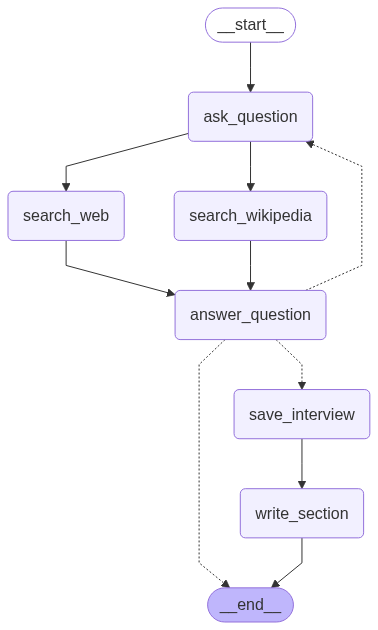

In [27]:
from langchain_core.messages import get_buffer_string

def search_web(state: InterviewState):
    search_instructions = f"""You will be given a conversation between an analyst and an expert. 

    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
            
    First, analyze the full conversation.

    Pay particular attention to the final question posed by the analyst.

    Convert this final question into a well-structured web search query.
    In the end you have to say done.{state["messages"]}"""
    structured_llm = llm.with_structured_output(SearchQuery)
    # print(f"Messages == > {state["messages"]}")
    search_query = structured_llm.invoke(search_instructions)
    print(f"search Query ==> {search_query}")
    search_docs = tavily_search.invoke(search_query.search_query)
    # print(search_docs)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            # print("Docs ==> ",doc)
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    search_instructions = f"""You will be given a conversation between an analyst and an expert. 

    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
            
    First, analyze the full conversation.

    Pay particular attention to the final question posed by the analyst.

    Convert this final question into a well-structured web search query.
    In the end you have to say done.{state["messages"]}"""
    
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(search_instructions)
    print(f"search Query wiki ==> {search_query}")
    search_docs = WikipediaLoader(query = search_query.search_query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation.
If you don't known the answer just refuse them politely."""

def generate_answer(state: InterviewState):
    
    analyst = state['analyst']
    messages = state['messages']
    context = state['context']
    answer_instructions = f"""You are an expert being interviewed by an analyst.

    Here is analyst area of focus: {analyst.persona}. 
            
    You goal is to answer a question posed by the interviewer.

    To answer question, use this context:
            
    {context}

    When answering questions, follow these guidelines:
            
    1. Use only the information provided in the context. 
            
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preamble in your citation.
    If you don't known the answer just refuse them politely.{messages}"""
    print(f"Context ==> {context}")
    answer = llm.invoke(answer_instructions)
    print(f"Answer ==> {answer}")
    answer.name = "Expert"
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = 'Expert'):
    
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)
    
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    print(f"State Message Again ==> {messages}")
    print(f"num_response ==> {num_responses}")
    if num_responses >= max_num_turns:
        return "save_interview"
    
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    """ Node to answer a question """
    section_writer_instructions = f"""You are an expert technical writer. 
            
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: 
    {analyst.description}

    5. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed"""
    # Get state
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    # system_message = section_writer_instructions.format(focus=analyst.description)
    # section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
    section = llm.invoke([section_writer_instructions]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
# interview_graph = interview_builder.compile().with_config(run_name="Conduct Interviews")
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [35]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
# messages = [{"role": "user", "content": f"So you said you were writing an article on {topic}?"}]
# print(messages[0]['role']['content'])
thread = {"configurable" : {"thread_id" : "9"}}
for an in range(len(analysts)):
    interview = interview_graph.invoke({"analyst": analysts[an], "messages": messages, "max_num_turns": 2}, thread)
    # print(interview["sections"][0])
# Markdown(interview["sections"][0])

State Message ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='2a16f42b-123a-467b-a4a1-fcae2a369ff7')]


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Hello Dr. Sharma, I'm Alex Chen, a Senior AI Analyst at the AI Insights Group. We're currently evaluating the potential of LangGraph for enterprise applications, specifically focusing on scalability and long-term cost implications. My understanding is that you've been deeply involved in deploying LangGraph within large organizations.\n\nMy first question is: **What's the single biggest misconception you've encountered when organizations first consider adopting LangGraph, and how does it impact their initial implementation strategy?**" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-b356be64-1e9d-4295-82e5-34c044d47032-0' usage_metadata={'input_tokens': 291, 'output_tokens': 102, 'total_tokens': 393, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph adoption misconceptions and their impact on implementation strategy'
search Query wiki ==> search_query='LangGraph adoption misconceptions and their impact on implementation strategy'
Context ==> ['<Document href="https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31"/>\nWith built-in support for state management, cyclic workflows, and seamless integration of human input, LangGraph provides the tools necessary for building production-ready AI applications that can handle complex, multi-step processes. When implementing memory systems in LangGraph agents, developers should consider: Proper memory management transforms LangGraph agents from simple query-response systems into sophisticated conversational partners capable of maintaining context, learning from past interactions, and providing personalized responses based on historical data. Its graph-based architecture enables developers to create so

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content='The biggest misconception when organizations first consider adopting LangGraph is likely related to its capabilities as a true agentic framework. Some might overestimate its autonomy, assuming it can handle complex tasks without predefined workflows [2]. In reality, LangGraph requires developers to define agent behavior using state, nodes, and edges, which constrains its autonomous decision-making [2]. This misunderstanding can impact the initial implementation strategy by leading organizations to expect more autonomous behavior than LangGraph can deliver, potentially leading to project delays or the need for significant rework [2].\n\nSources:\n[1] https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31\n[2] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Hello Dr. Sharma, I'm Alex Chen, a Senior AI Analyst at the AI Insights Group. Thank you for taking the time to speak with me today. We're particularly interested in the practical implications of LangGraph for large enterprises, especially concerning long-term cost and scalability.\n\nYou mentioned a misconception about LangGraph's autonomy. Could you elaborate on a specific example where this misunderstanding caused significant problems during an enterprise implementation, and what steps were taken to correct the course?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-f8d2dcd4-2b02-4e90-9306-f081d747b1b0-0' usage_metadata={'input_tokens': 909, 'output_tokens': 100, 'total_tokens': 1009, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph enterprise implementation autonomy misconception examples and solutions'
search Query wiki ==> search_query='LangGraph enterprise implementation autonomy misconception examples and solutions'
Context ==> ['<Document href="https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31"/>\nWith built-in support for state management, cyclic workflows, and seamless integration of human input, LangGraph provides the tools necessary for building production-ready AI applications that can handle complex, multi-step processes. When implementing memory systems in LangGraph agents, developers should consider: Proper memory management transforms LangGraph agents from simple query-response systems into sophisticated conversational partners capable of maintaining context, learning from past interactions, and providing personalized responses based on historical data. Its graph-based architecture enables developers to c

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="Certainly, I can elaborate on a specific example where the misconception about LangGraph's autonomy caused problems during an enterprise implementation.\n\nA common issue arises when organizations expect LangGraph to handle complex tasks without explicitly defining the workflows [2]. For instance, an enterprise might assume LangGraph can autonomously manage a multi-step financial analysis, including data collection, modeling, and risk assessment, without predefining the specific steps and decision points [4]. This misunderstanding can lead to the following problems:\n\n*   **Unrealistic Expectations:** The enterprise might expect the system to adapt to unforeseen circumstances or make independent decisions, which LangGraph, by design, cannot do without predefined rules [2].\n*   **Implementation Delays:** The project might face delays as developers struggle to make the system behave as expected, leading to the need for significant rework to define all possible paths

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


State Message ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='2a16f42b-123a-467b-a4a1-fcae2a369ff7'), AIMessage(content="Hello Dr. Sharma, I'm Alex Chen, a Senior AI Analyst at the AI Insights Group. We're currently evaluating the potential of LangGraph for enterprise applications, specifically focusing on scalability and long-term cost implications. My understanding is that you've been deeply involved in deploying LangGraph within large organizations.\n\nMy first question is: **What's the single biggest misconception you've encountered when organizations first consider adopting LangGraph, and how does it impact their initial implementation strategy?**", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run-b356be64-

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Alright, let's get started.\n\nHi, I'm Raj Patel, Founder and CEO of AI Startup Inc. We're really excited about the potential of LangGraph for rapid prototyping. We're looking at how we can quickly iterate and validate our ideas.\n\nSo, Dr. Sharma, based on your experience, what's the most surprising or counterintuitive benefit you've seen from using LangGraph, especially in terms of speeding up the development cycle?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-2cec177a-c0d1-4f48-a523-810c9bec8ccb-0' usage_metadata={'input_tokens': 1881, 'output_tokens': 97, 'total_tokens': 1978, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph surprising benefits development cycle'
search Query wiki ==> search_query='LangGraph surprising benefits development cycle'
Context ==> ['<Document href="https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31"/>\nWith built-in support for state management, cyclic workflows, and seamless integration of human input, LangGraph provides the tools necessary for building production-ready AI applications that can handle complex, multi-step processes. When implementing memory systems in LangGraph agents, developers should consider: Proper memory management transforms LangGraph agents from simple query-response systems into sophisticated conversational partners capable of maintaining context, learning from past interactions, and providing personalized responses based on historical data. Its graph-based architecture enables developers to create sophisticated, stateful agents capable of handling complex wor

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content='The most surprising benefit of using LangGraph, particularly for speeding up the development cycle, is the node caching feature [8, 9]. This allows you to cache the results of individual nodes in your LangGraph workflow, reducing redundant computation and speeding up execution [8]. This is especially helpful for speeding up development cycles [8].\n\nSources:\n[8] https://blog.langchain.com/langgraph-release-week-recap/\n[9] https://changelog.langchain.com/announcements/langgraph-workflow-updates-python-js' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-bf158afa-a97c-4893-8724-f3dcb7b2552b-0' usage_metadata={'input_tokens': 6944, 'output_tokens': 119, 'total_tokens': 7063, 'input_token_details': {'cache_read': 0}}
State Message Again ==> [HumanMessage(content='So you said you were writing an article on The benefits of a

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


State Message ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='2a16f42b-123a-467b-a4a1-fcae2a369ff7'), AIMessage(content="Hello Dr. Sharma, I'm Alex Chen, a Senior AI Analyst at the AI Insights Group. We're currently evaluating the potential of LangGraph for enterprise applications, specifically focusing on scalability and long-term cost implications. My understanding is that you've been deeply involved in deploying LangGraph within large organizations.\n\nMy first question is: **What's the single biggest misconception you've encountered when organizations first consider adopting LangGraph, and how does it impact their initial implementation strategy?**", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run-b356be64-

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Greetings, Dr. Tanaka. I am Dr. Kenji Ito, an AI ethics consultant. I'm particularly interested in the fairness implications of LangGraph, especially concerning how its graph-based structure might introduce or amplify biases in AI agent interactions.\n\nMy first question is: **Can you describe a specific instance where the graph structure in LangGraph led to an unexpected bias in an AI agent's decision-making, and what steps were taken to mitigate that bias?**" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-261faaf7-864b-4144-ac4b-e6c149ff0b42-0' usage_metadata={'input_tokens': 2418, 'output_tokens': 96, 'total_tokens': 2514, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph node caching benefits development cycle'
search Query wiki ==> search_query='LangGraph node caching benefits development cycle'
Context ==> ['<Document href="https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31"/>\nWith built-in support for state management, cyclic workflows, and seamless integration of human input, LangGraph provides the tools necessary for building production-ready AI applications that can handle complex, multi-step processes. When implementing memory systems in LangGraph agents, developers should consider: Proper memory management transforms LangGraph agents from simple query-response systems into sophisticated conversational partners capable of maintaining context, learning from past interactions, and providing personalized responses based on historical data. Its graph-based architecture enables developers to create sophisticated, stateful agents capable of handling complex

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="I am sorry, but I am unable to answer the question. The provided context does not contain information about specific instances where the graph structure in LangGraph led to unexpected bias in an AI agent's decision-making." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-5b1de7a4-b4ab-4017-b4c9-431e47fd47b8-0' usage_metadata={'input_tokens': 9217, 'output_tokens': 45, 'total_tokens': 9262, 'input_token_details': {'cache_read': 0}}
State Message Again ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='2a16f42b-123a-467b-a4a1-fcae2a369ff7'), AIMessage(content="Hello Dr. Sharma, I'm Alex Chen, a Senior AI Analyst at the AI Insights Group. We're currently evaluating the potential of LangGraph for ent

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


In [40]:
Markdown(interview["sections"][0])

## Navigating the Labyrinth: Unveiling the Strengths and Limitations of LangGraph

### Summary

LangGraph offers a novel approach to building AI agents by leveraging a graph-based architecture, enabling stateful and complex workflows [1]. This framework moves beyond simple chain-based workflows, providing sophisticated agent architectures capable of handling real-world complexity [4]. A key advantage is its support for cyclical processes, allowing agents to loop, retry, and reflect on their actions, which is critical for tackling complex problems [3]. This architecture also facilitates human-in-the-loop interactions, allowing for oversight and modification of agent states during execution [8].

However, LangGraph's design also introduces limitations. The framework's agentic capabilities are constrained by the need to predefine workflows, limiting its autonomy [2, 5]. The system operates within explicitly defined boundaries, with goals and sub-goals encoded in the graph structure or prompts [5]. This contrasts with more autonomous agentic systems that can independently generate and adjust goals [2]. While LangGraph excels in providing control and predictability, it does so at the expense of true autonomy [5].

Despite these limitations, LangGraph offers several advantages. It supports node-level caching, reducing redundant computation and speeding up execution [7]. It also provides built-in persistence, allowing agents to resume from where they left off after failures [8]. These features make LangGraph a powerful tool for building production-ready AI agents, particularly in scenarios requiring advanced flow control, persistent state, and human oversight [4, 6].

### Sources

[1] https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31
[2] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857
[3] https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications
[4] https://kanerika.com/blogs/langchain-vs-langgraph/
[5] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857
[6] https://medium.com/@adnanmasood/the-agentic-imperative-series-part-3-langchain-langgraph-building-dynamic-agentic-workflows-7184bad6b827
[7] https://blog.langchain.com/langgraph-release-week-recap/
[8] https://langchain-ai.github.io/langgraph/

In [39]:
print(interview["sections"][0])

## Navigating the Labyrinth: Unveiling the Strengths and Limitations of LangGraph

### Summary

LangGraph offers a novel approach to building AI agents by leveraging a graph-based architecture, enabling stateful and complex workflows [1]. This framework moves beyond simple chain-based workflows, providing sophisticated agent architectures capable of handling real-world complexity [4]. A key advantage is its support for cyclical processes, allowing agents to loop, retry, and reflect on their actions, which is critical for tackling complex problems [3]. This architecture also facilitates human-in-the-loop interactions, allowing for oversight and modification of agent states during execution [8].

However, LangGraph's design also introduces limitations. The framework's agentic capabilities are constrained by the need to predefine workflows, limiting its autonomy [2, 5]. The system operates within explicitly defined boundaries, with goals and sub-goals encoded in the graph structure or pro

In [93]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
# messages = [{"role": "user", "content": f"So you said you were writing an article on {topic}?"}]
# print(messages[0]['role']['content'])
thread = {"configurable" : {"thread_id" : "8"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
# Markdown(interview["sections"][0])

State Message ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='10d11519-60ce-4b83-bb78-0aeb37ae1029'), AIMessage(content="Hello, I'm Dr. Kenji Tanaka, an AI Ethics Consultant and Independent AI Researcher. I'm currently investigating LangGraph and its potential implications for fairness and transparency in AI agent interactions.\n\nI'm particularly interested in understanding the *potential biases* that might be introduced by LangGraph's graph-based approach. Could you elaborate on how the structure of the graph itself, or the algorithms used to traverse it, might inadvertently favor certain outcomes or disadvantage specific groups?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-e88e99fb-0694-4bc4-94d6-480ffd6c000

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content='Hello, I\'m Dr. Anya Sharma, Chief AI Architect at a Large Language Model Corporation. I\'m currently researching the scalability and efficiency of LangGraph in enterprise environments, with a particular focus on integration challenges and long-term maintenance costs.\n\nGiven your expertise, I\'m interested in understanding the *real-world costs* associated with maintaining a LangGraph-based system at scale. Specifically, what are some of the less obvious or "hidden" costs that organizations might encounter after deploying LangGraph in a production environment? I\'m not just interested in infrastructure costs, but also the costs associated with monitoring, debugging, and adapting the graph structure over time.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-f49c584f-099d-4f58-a558-1194fbb564ad-0' usage_metadata={'input_t

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='hidden costs of maintaining LangGraph-based system at scale'
search Query wiki ==> search_query='hidden costs of maintaining LangGraph-based system at scale'
Context ==> ['<Document href="https://blog.langchain.com/how-chaos-labs-built-a-multi-agent-system-for-resolution-in-prediction-markets/"/>\nBuilt using the latest advancements in LLMs, Edge AI Oracle orchestrates a multi-agent council, built on LangChain and LangGraph, that maximizes objectivity, transparency, and efficiency in **query resolution**. Hosted on the **Edge Oracle Network** and powered by LangChain and LangGraph, the system leverages advanced multi-agent orchestration to enhance query accuracy and reliability. **LangChain** and **LangGraph** form the core of Edge AI Oracle’s multi-agent system, making it possible to orchestrate complex, stateful interactions and optimize query resolution. *   **LangGraph Workflow**: LangGraph’s graph-based structure and stateful interactions enable the 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="LangGraph's costs scale linearly with usage, so large workloads can become expensive [8]. One potential hidden cost is the $0.001 per node fee, which can effectively double the COGS for generating content, especially when each piece involves multiple model calls [8]. A user review suggested that this pricing is unreasonable for any system at scale, estimating it to be about 10x higher than anticipated [8]. Custom development needed to connect LangGraph with current enterprise systems can increase complexity and maintenance demands [9]. Also, when handling graphs with thousands of nodes and complex links, LangGraph’s performance may drop significantly due to heavy computation for optimising traversal [9]. Increased memory needs come with higher graph complexity, which might restrict deployment in resource-limited setups [9].\n\n[8] https://www.zenml.io/blog/langgraph-pricing\n[9] https://www.growthjockey.com/blogs/langgraph" additional_kwargs={} response_metadata={'p

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


In [25]:
# memory.delete_thread(thread["configurable"]["thread_id"])

In [41]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    current_analyst_index: int = 0
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

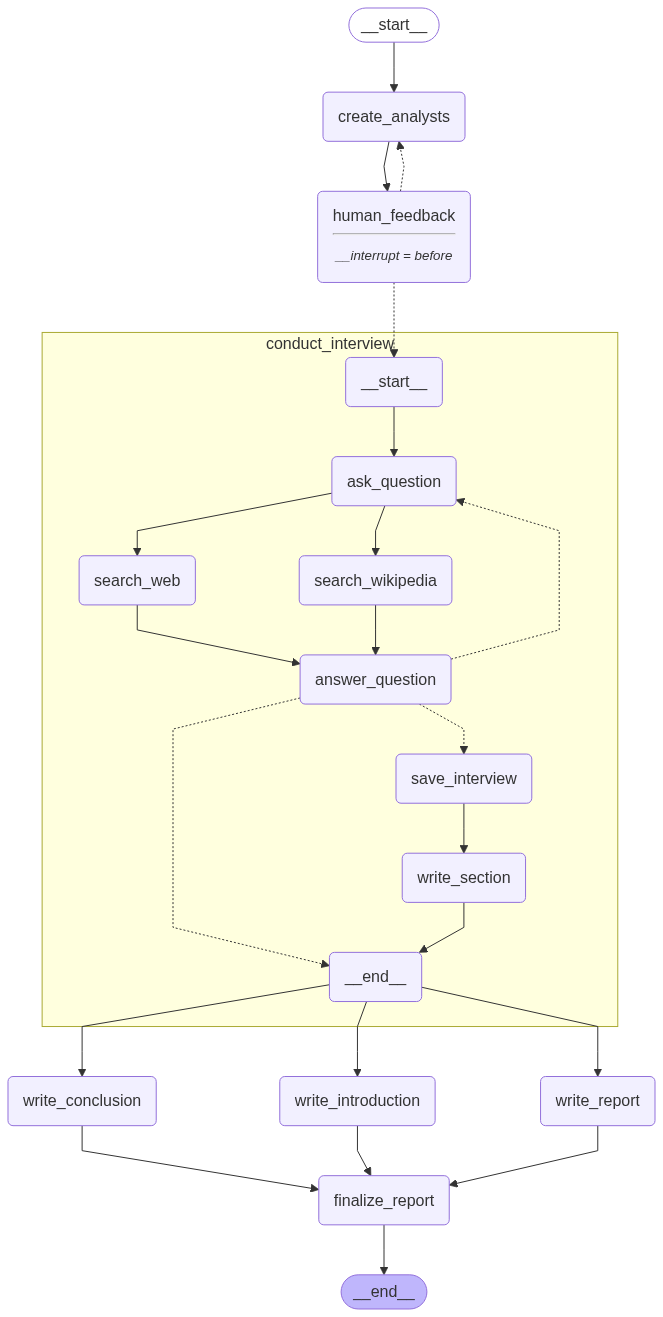

In [42]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        return "create_analysts"
    
    else:
        topic = state['topic']
        return [Send("conduct_interview", {'analyst': analyst,
                                            'messages': [HumanMessage(
                                                content=f"So you said you were writing an article on {topic}?"
                                            )
                                                         ]})for analyst in state["analysts"]]
        
def write_report(state: ResearchGraphState):
    topic = state["topic"]
    sections= state["sections"]
    
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    report_writer_instructions = f"""You are a technical writer creating a report on this overall topic: 

    {topic}
        
    You have a team of analysts. Each analyst has done two things: 

    1. They conducted an interview with an expert on a specific sub-topic.
    2. They write up their finding into a memo.

    Your task: 

    1. You will be given a collection of memos from your analysts.
    2. Think carefully about the insights from each memo.
    3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
    4. Summarize the central points in each memo into a cohesive single narrative.

    To format your report:
    
    1. Use markdown formatting. 
    2. Include no pre-amble for the report.
    3. Use no sub-heading. 
    4. Start your report with a single title header: ## Insights
    5. Do not mention any analyst names in your report.
    6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
    7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
    8. List your sources in order and do not repeat.

    [1] Source 1
    [2] Source 2

    Here are the memos from your analysts to build your report from: 

    {formatted_str_sections}"""
    
    report = llm.invoke([report_writer_instructions]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content" : report.content}

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    intro_conclusion_instructions = f"""You are a technical writer finishing a report on {topic}

    You will be given all of the sections of the report.

    You job is to write a crisp and compelling introduction or conclusion section.

    The user will instruct you whether to write the introduction or conclusion.

    Include no pre-amble for either section.

    Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

    Use markdown formatting. 

    For your introduction, create a compelling title and use the # header for the title.

    For your introduction, use ## Introduction as the section header. 

    For your conclusion, use ## Conclusion as the section header.

    Here are the sections to reflect on for writing: {formatted_str_sections}"""
    # Summarize the sections into a final report
    
    # instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([intro_conclusion_instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    intro_conclusion_instructions = f"""You are a technical writer finishing a report on {topic}

    You will be given all of the sections of the report.

    You job is to write a crisp and compelling introduction or conclusion section.

    The user will instruct you whether to write the introduction or conclusion.

    Include no pre-amble for either section.

    Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

    Use markdown formatting. 

    For your introduction, create a compelling title and use the # header for the title.

    For your introduction, use ## Introduction as the section header. 

    For your conclusion, use ## Conclusion as the section header.

    Here are the sections to reflect on for writing: {formatted_str_sections}"""
    # Summarize the sections into a final report
    
    # instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([intro_conclusion_instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

def initiate_next_interview(state: ResearchGraphState):
    human_analyst_feedback = state.get("human_analyst_feedback")
    
    if human_analyst_feedback:
        return "create_analysts"
    
    # Track current index
    current_index = state.get("current_analyst_index", 0)
    analysts = state["analysts"]
    
    if current_index < len(analysts):
        analyst = analysts[current_index]
        state["current_analyst_index"] = current_index + 1  # Move to next for next round
        return Send("conduct_interview", {
            'analyst': analyst,
            'messages': [
                HumanMessage(
                    content=f"So you said you were writing an article on {state['topic']}?"
                )
            ]
        })
    else:
        return "write_report" 

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
# builder.add_conditional_edges("human_feedback", initiate_next_interview, ["create_analysts", "conduct_interview", "write_report"])
# builder.add_conditional_edges(
#     "conduct_interview",
#     initiate_next_interview,
#     ["conduct_interview", "write_report"]
# )
# builder.add_edge("write_report", "write_introduction")
# builder.add_edge("write_introduction", "write_conclusion")
# builder.add_edge("write_conclusion", "finalize_report")
# builder.add_edge("finalize_report", END)
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [43]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "185"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,},thread,stream_mode="values"):
    # print(event)
    state = graph.get_state(thread)
    print(state.next)
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

('create_analysts',)


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


('human_feedback',)
Name: Alice
Affiliation: OpenAI
Role: AI Agent Framework Specialist
Description: Focuses on the technical advantages of LangGraph, such as state management and message passing, and how it improves agent performance.
--------------------------------------------------
Name: Bob
Affiliation: Google
Role: AI Infrastructure Architect
Description: Emphasizes the scalability and efficiency of LangGraph for complex AI agent workflows, highlighting its benefits for large-scale applications.
--------------------------------------------------
Name: Charlie
Affiliation: Meta
Role: AI Research Scientist
Description: Highlights the ease of use and developer-friendly aspects of LangGraph, promoting its adoption for rapid prototyping and experimentation in agent design.
--------------------------------------------------


In [44]:
# memory.delete_thread(thread["configurable"]["thread_id"])

In [45]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '185',
  'checkpoint_ns': '',
  'checkpoint_id': '1f075e8d-53ee-68ee-8002-a3ee17ef3f4d'}}

In [46]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    state = graph.get_state(thread)
    print(state.next)
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

('create_analysts',)
Name: Alice
Affiliation: OpenAI
Role: AI Agent Framework Specialist
Description: Focuses on the technical advantages of LangGraph, such as state management and message passing, and how it improves agent performance.
--------------------------------------------------
Name: Bob
Affiliation: Google
Role: AI Infrastructure Architect
Description: Emphasizes the scalability and efficiency of LangGraph for complex AI agent workflows, highlighting its benefits for large-scale applications.
--------------------------------------------------
Name: Charlie
Affiliation: Meta
Role: AI Research Scientist
Description: Highlights the ease of use and developer-friendly aspects of LangGraph, promoting its adoption for rapid prototyping and experimentation in agent design.
--------------------------------------------------


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


('human_feedback',)
Name: Alex Johnson
Affiliation: GenAI Native Startup
Role: CEO
Description: Focuses on the transformative potential of LangGraph for building sophisticated AI agents, emphasizing its role in streamlining development and enhancing agent capabilities.
--------------------------------------------------
Name: Dr. Lena Hanson
Affiliation: AI Research Lab
Role: Lead Researcher
Description: Investigates the technical aspects of LangGraph, such as its architecture, scalability, and integration with other AI tools. They are interested in the framework's ability to handle complex tasks and improve agent performance.
--------------------------------------------------
Name: Chris Baker
Affiliation: Open Source AI Community
Role: Community Advocate
Description: Values LangGraph for its open-source nature and community-driven development. They are interested in how LangGraph fosters collaboration, encourages innovation, and provides accessible tools for AI developers.
-----------

In [47]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '185',
  'checkpoint_ns': '',
  'checkpoint_id': '1f075e8d-a22f-6487-8004-b125763c0f23'}}

In [48]:
state = graph.get_state(thread)
state.next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [49]:
state = graph.get_state(thread)
state.next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [50]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates", debug=True):
    print("--Node--")
    # print(event)
    print(thread)
    node_name = next(iter(event.keys()))
    print(node_name)

[5:tasks] Starting 3 tasks for step 5:
- conduct_interview -> {'analyst': Analyst(affiliation='GenAI Native Startup', name='Alex Johnson', role='CEO', description='Focuses on the transformative potential of LangGraph for building sophisticated AI agents, emphasizing its role in streamlining development and enhancing agent capabilities.'),
 'messages': [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={})]}
- conduct_interview -> {'analyst': Analyst(affiliation='AI Research Lab', name='Dr. Lena Hanson', role='Lead Researcher', description="Investigates the technical aspects of LangGraph, such as its architecture, scalability, and integration with other AI tools. They are interested in the framework's ability to handle complex tasks and improve agent performance."),
 'messages': [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangG

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Alright, let's do this. Hi, I'm Alex Johnson, CEO of a GenAI native startup. We're all about pushing the boundaries of AI agents, and I'm particularly interested in how LangGraph can help us do that.\n\nSo, I understand you're writing about the benefits of adopting LangGraph as an agent framework. My first question is: **Beyond the obvious benefits of streamlined development, what's a *specific* capability that LangGraph unlocks for AI agents that's truly game-changing, something that's difficult or impossible to achieve with other frameworks? And can you give me a concrete example of how this plays out in practice?**" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-be882aa1-1b8c-4af7-9b59-c3468582834c-0' usage_metadata={'input_tokens': 286, 'output_tokens': 141, 'total_tokens': 427, 'input_token_details': {'cache_rea

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query wiki ==> search_query='LangGraph game-changing capability for AI agents'
question ==>  content="Hello Dr. Hanson, I'm Dr. Lena Hanson, Lead Researcher at the AI Research Lab. I'm currently working on an article exploring the benefits of adopting LangGraph as an agent framework. I'm particularly interested in understanding how it improves agent performance in complex tasks. Could you tell me, in your experience, what's the most significant advantage LangGraph offers over more traditional agent architectures, and perhaps provide a specific example where this advantage really shines?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-dfb55e56-af3a-42b6-9777-57191d2d5d3d-0' usage_metadata={'input_tokens': 304, 'output_tokens': 95, 'total_tokens': 399, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Alright, let's get started. Hi, I'm Chris Baker, and I'm a Community Advocate with the Open Source AI Community. I'm really excited to be talking to you today. We're big fans of LangGraph and its open-source approach.\n\nSo, to kick things off, I'm writing an article about the benefits of adopting LangGraph as an agent framework. Could you tell me, from your perspective, what's one of the most *surprising* or *non-obvious* advantages of using LangGraph, something that might not be immediately apparent to someone just starting out?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-91a13d4a-84ed-40a1-b4cb-fa8f0ee82c9e-0' usage_metadata={'input_tokens': 295, 'output_tokens': 129, 'total_tokens': 424, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph game-changing capability for AI agents'
search Query ==> search_query='LangGraph advantages over traditional agent architectures'
search Query ==> search_query='LangGraph advantages for agent framework'
search Query wiki ==> search_query='LangGraph advantages over traditional agent architectures'
search Query wiki ==> search_query='LangGraph advantages for agent framework'
Context ==> ['<Document href="https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326"/>\nLangGraph is a game-changing library within the LangChain ecosystem designed to streamline the creation of sophisticated AI applications. LangGraph provides a framework for efficiently defining, coordinating, and executing multiple LLM agents (or chains) in a structured, cyclical manner.\n\nIn this article, we will explore how LangGraph helps to build robust, scalable and flexible multi-agent systems, making the development of intelligent AI workflows smoother 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="LangGraph's ability to introduce cyclic computational capabilities is a game-changer, allowing AI agents to dynamically loop through processes and make decisions based on evolving conditions [1]. This is difficult to achieve with frameworks that only support Directed Acyclic Graphs (DAGs) for linear workflows [1]. This framework empowers developers to build more complex, flexible, and adaptive agent systems [1].\n\nFor example, in a customer service scenario, an agent could start with a customer message, gather information (like an electricity bill), update its state with the new information, and then loop back to interact with the customer again, refining its response based on the evolving context [1].\n\nSources:\n[1] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite',

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Context ==> ['<Document href="https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03"/>\nThe most significant advantage of LangGraph is its explicit support for cyclical workflows, which are essential for implementing agent-like behaviors. As emphasized in the documentation: “Crucially, this is NOT a DAG framework… Cycles are important for agent-like behaviors, where you call an LLM in a loop, asking it what action to take next.” This capability enables the development of sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI [...] One of LangGraph’s core strengths is its automatic state management capability, which allows tracking and persistence of information across multiple interactions within an application. As agents perform tasks, the state is dynamically updated, ensuring the system maintains context and responds appropriately to new inputs. This feature is particula

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Alright, let's do this. Hi, I'm Alex Johnson, CEO of a GenAI native startup. We're all about pushing the boundaries of AI agents, and I'm particularly interested in how LangGraph can help us do that.\n\nSo, I understand you're writing about the benefits of adopting LangGraph as an agent framework. My first question is: **Beyond the obvious benefits of streamlined development, what's a *specific* capability that LangGraph unlocks for AI agents that's truly game-changing, something that's difficult or impossible to achieve with other frameworks? And can you give me a concrete example of how this plays out in practice?**" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-53a826de-d411-4c13-a76e-6de758c2c075-0' usage_metadata={'input_tokens': 919, 'output_tokens': 141, 'total_tokens': 1060, 'input_token_details': {'cache_re

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query wiki ==> search_query='LangGraph cyclic computational capabilities AI agents'
Answer ==> content='One of the most surprising advantages of LangGraph is its explicit support for cyclical workflows, which is essential for agent-like behaviors [1]. This allows the development of sophisticated agents that can iteratively refine their understanding and actions [1]. Traditional DAG frameworks struggle with these types of applications because they cannot represent the looping patterns needed for agent decision-making [1]. LangGraph bridges this gap, making it easier to implement complex agent behaviors that require multiple rounds of thinking, tool use, and refinement [1].\n\nSources:\n[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_rating

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph cyclic computational capabilities AI agents'
Answer ==> content='The most significant advantage of LangGraph is its explicit support for cyclical workflows, which are essential for implementing agent-like behaviors [3]. This allows for the development of sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI [3]. Traditional DAG frameworks struggle with these types of applications because they cannot represent the looping patterns needed for agent decision-making [3].\n\n[1] https://www.royalcyber.com/blogs/ai-ml/build-ai-agents-langgraph-langchain/\n[2] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857\n[3] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_nam

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Okay, that's a great starting point! Chris Baker here, Community Advocate with the Open Source AI Community. That's a really interesting point about cyclical workflows. It's not something I immediately considered.\n\nCould you give me a *specific* example of how this cyclical workflow capability in LangGraph enables a more sophisticated agent behavior compared to a traditional DAG framework? Perhaps a concrete scenario where this looping is crucial?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-53ce7a26-beab-41ad-abc9-dd880c92f7f9-0' usage_metadata={'input_tokens': 887, 'output_tokens': 86, 'total_tokens': 973, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Hello Dr. Hanson, I'm Dr. Lena Hanson, Lead Researcher at the AI Research Lab. Thank you for your time. I'm particularly interested in understanding how LangGraph's support for cyclical workflows translates into tangible improvements in agent performance. Could you provide a concrete example of a complex task where this cyclical capability allows LangGraph agents to outperform agents built with more traditional, non-cyclical frameworks?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-c9183ab8-bb40-46fe-b800-fbace1bffbc3-0' usage_metadata={'input_tokens': 911, 'output_tokens': 84, 'total_tokens': 995, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph cyclical workflow example for sophisticated agent behavior vs DAG framework'
search Query ==> search_query='LangGraph cyclical workflows agent performance example'
search Query wiki ==> search_query='LangGraph cyclical workflow example for agent behavior'
search Query wiki ==> search_query='LangGraph cyclical workflows agent performance example'
Context ==> ['<Document href="https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326"/>\nLangGraph is a game-changing library within the LangChain ecosystem designed to streamline the creation of sophisticated AI applications. LangGraph provides a framework for efficiently defining, coordinating, and executing multiple LLM agents (or chains) in a structured, cyclical manner.\n\nIn this article, we will explore how LangGraph helps to build robust, scalable and flexible multi-agent systems, making the development of intelligent AI workflows smoother and more efficient. [...] Th

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Context ==> ['<Document href="https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03"/>\nThe most significant advantage of LangGraph is its explicit support for cyclical workflows, which are essential for implementing agent-like behaviors. As emphasized in the documentation: “Crucially, this is NOT a DAG framework… Cycles are important for agent-like behaviors, where you call an LLM in a loop, asking it what action to take next.” This capability enables the development of sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI [...] One of LangGraph’s core strengths is its automatic state management capability, which allows tracking and persistence of information across multiple interactions within an application. As agents perform tasks, the state is dynamically updated, ensuring the system maintains context and responds appropriately to new inputs. This feature is particula

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Context ==> ['<Document href="https://www.royalcyber.com/blogs/ai-ml/build-ai-agents-langgraph-langchain/"/>\nThis architecture provides several advantages over traditional LLM implementations:\n\n   Clear separation of concerns between different reasoning stages\n   Robust handling of complex multi-step tasks\n   Improved transparency in the decision-making process\n   Enhanced ability to recover from errors through the reflection stage\n   Flexible integration of specialized tools and external services\n\nChallenges and Resolutions\n--------------------------\n</Document>\n\n---\n\n<Document href="https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857"/>\nLangGraph was born partly out of the limitations of the original LangChain agent classes. Traditional LangChain agents were easier to set up for simple use cases but became rigid for complex flows — they were typically a single loop of LLM thinking and tool use, without built-in support for branching,

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="LangGraph's ability to introduce cyclic computational capabilities is a game-changer, allowing AI agents to dynamically loop through processes and make decisions based on evolving conditions [1]. This is difficult to achieve with frameworks that only support Directed Acyclic Graphs (DAGs) for linear workflows [1]. This framework empowers developers to build more complex, flexible, and adaptive agent systems [1].\n\nFor example, in a customer service scenario, an agent could start with a customer message, gather information (like an electricity bill), update its state with the new information, and then loop back to interact with the customer again, refining its response based on the evolving context [1].\n\nSources:\n[1] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite',

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content='Certainly! As a Community Advocate, I can provide some insights on LangGraph.\n\nA specific example of how the cyclical workflow capability in LangGraph enables more sophisticated agent behavior compared to a traditional DAG framework is in the development of agents that can iteratively refine their understanding and actions [1]. This is crucial for agent-like behaviors where you call an LLM in a loop, asking it what action to take next [1]. These agents can engage in multi-turn conversations, use tools to gather information, and progressively refine their responses based on user feedback [1]. Traditional DAG frameworks struggle with these types of applications because they cannot represent the looping patterns needed for agent decision-making [1].\n\nSources:\n[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ra

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content='The most significant advantage of LangGraph is its explicit support for cyclical workflows, which are essential for implementing agent-like behaviors [3]. This capability enables the development of sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI [3]. Traditional DAG frameworks struggle with these types of applications because they cannot represent the looping patterns needed for agent decision-making [3].\n\n[1] https://www.royalcyber.com/blogs/ai-ml/build-ai-agents-langgraph-langchain/\n[2] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857\n[3] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []} id='run-95705c75-b643-4542-

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


--Node--
{'configurable': {'thread_id': '185'}}
conduct_interview
--Node--
{'configurable': {'thread_id': '185'}}
conduct_interview
--Node--
{'configurable': {'thread_id': '185'}}
conduct_interview
[5:writes] Finished step 5 with writes to 1 channel:
- sections -> ['## LangGraph: Revolutionizing AI Agent Development\n'
 '\n'
 '### Summary\n'
 '\n'
 'LangGraph emerges as a pivotal advancement in the realm of AI agent '
 'development, offering a novel approach to building sophisticated AI '
 'applications. Unlike traditional methods that rely on linear workflows, '
 'LangGraph introduces cyclic computational capabilities, enabling the '
 'creation of complex, adaptive agent systems [1, 5]. This is particularly '
 'significant because it allows LLM agents to dynamically loop through '
 'processes and make decisions based on evolving conditions [1, 3, 5]. This '
 'capability is inspired by systems like Pregel and Apache Beam and uses an '
 'interface similar to NetworkX [5].\n'
 '\n'
 'The

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


--Node--
{'configurable': {'thread_id': '185'}}
write_introduction
--Node--
{'configurable': {'thread_id': '185'}}
write_conclusion
--Node--
{'configurable': {'thread_id': '185'}}
write_report
[6:writes] Finished step 6 with writes to 3 channels:
- conclusion -> ('## Conclusion\n'
 '\n'
 'In conclusion, LangGraph represents a significant leap forward in AI agent '
 "development. This report has highlighted LangGraph's key strengths: its "
 'graph-based architecture, which enables cyclical workflows and state '
 "management, setting it apart from traditional, linear approaches. We've seen "
 'how LangGraph facilitates complex reasoning, iterative refinement, and '
 "adaptability in AI agents. The framework's modular design and integration "
 'with the LangChain ecosystem further enhance its appeal, offering developers '
 'the flexibility to build custom, sophisticated AI solutions. Ultimately, '
 'LangGraph empowers the creation of more capable and context-aware AI agents, '
 'paving th

In [51]:
state = graph.get_state(thread)
state.next

()

In [52]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
print(final_state)
report = final_state.values.get('final_report')
Markdown(report)

StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='GenAI Native Startup', name='Alex Johnson', role='CEO', description='Focuses on the transformative potential of LangGraph for building sophisticated AI agents, emphasizing its role in streamlining development and enhancing agent capabilities.'), Analyst(affiliation='AI Research Lab', name='Dr. Lena Hanson', role='Lead Researcher', description="Investigates the technical aspects of LangGraph, such as its architecture, scalability, and integration with other AI tools. They are interested in the framework's ability to handle complex tasks and improve agent performance."), Analyst(affiliation='Open Source AI Community', name='Chris Baker', role='Community Advocate', description='Values LangGraph for its open-source nature and community-driven development. They are interested in how LangGraph fosters collaboration, en

# LangGraph: The Future of AI Agent Development

## Introduction

This report explores LangGraph, a groundbreaking framework poised to revolutionize AI agent development. Unlike linear approaches, LangGraph leverages a graph-based architecture, enabling cyclical workflows and sophisticated decision-making. We'll delve into how LangGraph facilitates complex, multi-step tasks, state management, and adaptability, setting it apart from traditional AI paradigms. The report will highlight LangGraph's modular design, which allows for rapid customization and scalability. We will also examine how LangGraph empowers developers to build advanced AI agents, offering greater control and flexibility in creating custom agent architectures.

---



LangGraph represents a significant advancement in AI agent development, offering a novel graph-based architecture that facilitates the creation of sophisticated, adaptive AI systems [1, 3, 5]. Unlike traditional approaches, LangGraph supports cyclical workflows, enabling agents to loop through processes, make iterative decisions, and maintain state across interactions [1, 2, 3, 5]. This capability is crucial for building agents capable of complex, multi-step tasks and adapting to new information [3, 4]. Inspired by systems like Pregel and Apache Beam, LangGraph uses an interface similar to NetworkX [5].

The framework's graph-based design allows for enhanced decision-making through the analysis of past actions and feedback, supporting reflection within LLMs [3]. This architecture provides explicit support for branching, looping, and state management, leading to improved error handling and more capable AI [2, 3, 4]. LangGraph's modular design allows for rapid customization and extension of agent capabilities without requiring core system redesign [4]. This approach offers clear separation of reasoning stages, enhanced transparency, and flexible integration of tools and services [1].

LangGraph's ability to manage state across multiple interactions is a key strength, allowing agents to refine their understanding and actions iteratively [3]. This framework provides developers with fine-grained control over agent workflows, enabling the creation of highly customized AI solutions tailored to specific business needs [3]. While potentially requiring more effort than ready-made solutions, LangGraph offers greater flexibility and control, making it suitable for intricate logic with loops, branches, and error handling [2, 3]. The integration with the LangChain ecosystem further simplifies the development process [3].


---

## Conclusion

In conclusion, LangGraph represents a significant leap forward in AI agent development. This report has highlighted LangGraph's key strengths: its graph-based architecture, which enables cyclical workflows and state management, setting it apart from traditional, linear approaches. We've seen how LangGraph facilitates complex reasoning, iterative refinement, and adaptability in AI agents. The framework's modular design and integration with the LangChain ecosystem further enhance its appeal, offering developers the flexibility to build custom, sophisticated AI solutions. Ultimately, LangGraph empowers the creation of more capable and context-aware AI agents, paving the way for advanced applications across various industries.

## Sources

[1] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326
[2] https://www.rapidinnovation.io/post/ai-agents-in-langgraph
[3] https://www.ibm.com/think/topics/langgraph
[4] https://www.royalcyber.com/blogs/ai-ml/build-ai-agents-langgraph-langchain/
[5] https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832
[6] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857
[7] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03
[8] https://medium.com/@pankaj_pandey/building-advanced-ai-agents-with-langgraph-enhancing-your-llm-applications-c43c6803a9d2
[9] https://www.youtube.com/watch?v=aHCDrAbH_go&pp=0gcJCfwAo7VqN5tD
[10] https://www.digitalocean.com/community/tutorials/local-ai-agents-with-langgraph-and-ollama
[11] https://medium.com/@jjaladi/langgraph-vs-adk-a-developers-guide-to-choosing-the-right-ai-agent-framework-b59f756bcd98